# ARPA Weather Station Data
This notebook is used for:
1) testing ARPA API functionalities
2) testing functions to be implemented in the plugin
3) testing libraries to be used and evaluate performances

First, it is necessary to get a token.
Go to Open Data Lombardia website (https://dati.lombardia.it/). Subscribe to the website and go to your profile settings. <br>
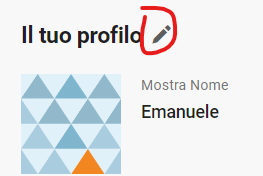 <br>
Modify your profile and open the "Opzioni per lo sviluppatore" tab. Create a new App Token to be used.


Useful notebook for Sodapy: https://github.com/xmunoz/sodapy/blob/master/examples/soql_queries.py

# TO-DO
- Check values


## Import libraries

In [3]:
import warnings
warnings.filterwarnings('ignore')

from sodapy import Socrata
import pandas as pd
from datetime import datetime, timedelta
import requests
from io import BytesIO
from zipfile import ZipFile
import os
import time
import dask.dataframe as dd

## Client

In [4]:
arpa_token = "riTLzYVRVdDaQtUkxDDaHRgJi" 
print(arpa_token)

riTLzYVRVdDaQtUkxDDaHRgJi


Pandas va installato anche se si installa prima Dask

Function to create a client session with the API using the token:

In [5]:
def connect_ARPA_api(token):
    """
    Function to connect to ARPA API.

        Parameters:
            - token (str): the ARPA token obtained from Open Data Lombardia website

        Returns:
            - client: client session
            
    """
    
    #Connect tu Open Data Lombardia using the token
    client = Socrata("www.dati.lombardia.it", app_token=token)

    return client

Import the code of the dataset. In this case "nf78-nj6b" is related to ARPA stations information containing:
1) sensors id
2) sensor type
3) unit
4) stations id
5) stations names
...

## Stations and sensors information

MAKE A FUNCTION THAT CONNECTS WITH TOKEN IF THAT IS PROVIDED

In [6]:
stationsId = "nf78-nj6b" # Select meteo stations dataset containing positions and information about sensors
client = connect_ARPA_api(arpa_token)
sensors_info = client.get_all(stationsId)

Create sensors dataframe:

In [7]:
def ARPA_sensors_info(sensors_info):
    """
    Functions to convert sensors information to Pandas dataframe and fix the data types.
        Parameters:
            - sensors_info: object obtained from Socrata with get request

        Returns:
            - df: dataframe containing ARPA sensors information
    
    """
    
    sensors_df = pd.DataFrame(sensors_info)
    sensors_df['idsensore']=sensors_df['idsensore'].astype(int)
    sensors_df['idstazione']=sensors_df['idstazione'].astype(int)
    sensors_df['quota']=sensors_df['quota'].astype(int)
    sensors_df['datastart']=pd.to_datetime(sensors_df['datastart'])
    sensors_df['datastop']=pd.to_datetime(sensors_df['datastop'])
      
    return sensors_df

In [8]:
sensors_df = ARPA_sensors_info(sensors_info)
sensors_df.dtypes

idsensore                               int32
tipologia                              object
unit_dimisura                          object
idstazione                              int32
nomestazione                           object
quota                                   int32
provincia                              object
datastart                      datetime64[ns]
storico                                object
cgb_nord                               object
cgb_est                                object
lng                                    object
lat                                    object
location                               object
:@computed_region_6hky_swhk            object
:@computed_region_ttgh_9sm5            object
datastop                       datetime64[ns]
dtype: object

In [9]:
unique_sensors_list = sensors_df['tipologia'].unique()
unique_sensors_list

array(['Precipitazione', 'Temperatura', 'Umidità Relativa',
       'Radiazione Globale', 'Direzione Vento', 'Velocità Vento',
       'Livello Idrometrico', 'Altezza Neve'], dtype=object)

Select the sensor type:

In [10]:
sensor_sel = "Temperatura"

In [11]:
sensors_list = (sensors_df.loc[sensors_df['tipologia'] == sensor_sel]).idsensore.tolist()  #& (sensors_df['storico'] == storic_data)
sensors_list_str = list(map(str, sensors_list))

In [12]:
# #Check sensori storici
# sensors_df.loc[sensors_df['storico'] == 'S']

Consideration: inside the plugin the data type for each columns must be set accordingly to QGIS data types.

Select sensor type and create a list of those sensors from the previous dataframe.

In [13]:
print(("Selected sensor: {sel}").format(sel=sensor_sel))
print(("Number of selected sensor: {sens_len}").format(sens_len=len(sensors_list)))

Selected sensor: Temperatura
Number of selected sensor: 248


## Define Dates

In [29]:
def check_dates(start_date, end_date):
    year_start = int(start_date[0:4])
    year_end = int(end_date[0:4])
    if year_start != year_end:
        raise Exception(("Dates must be in the same year! Years chosen are: {year_start} and {year_end}").format(year_start=year_start, year_end=year_end))
    else:
        start_date = datetime.strptime(start_date, "%Y-%m-%d %H:%M:%S")
        end_date = datetime.strptime(end_date, "%Y-%m-%d %H:%M:%S")
        year = year_start
    return year, start_date, end_date
    

In [31]:
start_date_str = "2021-01-01 00:00:00"
end_date_str = "2021-12-31 23:50:00"

year, start_date, end_date = check_dates(start_date_str, end_date_str)
year, start_date, end_date

(2021,
 datetime.datetime(2021, 1, 1, 0, 0),
 datetime.datetime(2021, 12, 31, 23, 50))

----

## API Time series
This part requires time series and relative information from the API. The output of this section is to obtain a dataframe that has the same characteristics as the dataframe obtained from the csv processing.

Following function is used to obtain minimum and maximum date available in ARPA API.

In [32]:
def req_ARPA_start_end_date_API(client):
    """
    Function to request the start and the end date of data available in the ARPA API.

      Parameters:
        - client: the client session

      Returns: 
        - start_API_date (str): starting date for available data inside the API.
        - end_API_date (str): ending date for available data inside the API.
        
    """
    
    #Weather sensors dataset id on Open Data Lombardia
    weather_sensor_id = "647i-nhxk"
    
    #Query
    query = """ select MAX(data), MIN(data) limit 9999999999999999"""

    #Get max and min dates from the list
    min_max_dates = client.get(weather_sensor_id, query=query)[0]
    
    #Start and minimum dates from the dict obtained from the API
    start_API_date = min_max_dates['MIN_data']
    end_API_date = min_max_dates['MAX_data']
    
    #Convert to datetime and add 1 day to end date to consider all the values inside the last day (e.g. 20/01/2023 23:10:00 won't be considered and the requested data will be untile 20/01/2023 00:00:00)
    start_API_date = datetime.strptime(start_API_date, "%Y-%m-%dT%H:%M:%S.%f")
    end_API_date = datetime.strptime(end_API_date, "%Y-%m-%dT%H:%M:%S.%f")
    
    print("The data from the API are available from: " ,start_API_date, " up to: ", end_API_date, ". Select data in this range.")

    return start_API_date, end_API_date

In [33]:
start_date_API, end_date_API = req_ARPA_start_end_date_API(client)

The data from the API are available from:  2023-01-01 00:00:00  up to:  2023-01-25 12:00:00 . Select data in this range.


Request data from API :

In [34]:
def req_ARPA_data_API(client, start_date, end_date, sensors_list):
    """
    Function to request data from available weather sensors in the ARPA API using a query.

      Parameters:
        - client: the client session
        - start date (str): the start date in yyy-mm-dd format
        - end date (str): the end date in yyy-mm-dd format
        
      Returns: 
        - time_series: time series of values requested with the query for all sensors
        
    """
    
    #Select the Open Data Lombardia Meteo sensors dataset
    weather_sensor_id = "647i-nhxk"
    
    #Convert to string in year-month-day format, accepted by ARPA query
    start_date = start_date.strftime("%Y-%m-%dT%H:%M:%S.%f")
    end_date = end_date.strftime("%Y-%m-%dT%H:%M:%S.%f")
    
    print("--- Starting request to ARPA API ---")
    
    t = time.time()
    
    #Query data
    query = """
      select
          *
      where data >= \'{}\' and data <= \'{}\' limit 9999999999999999
      """.format(start_date, end_date)

    #Get time series and evaluate time spent to request them
    time_series = client.get(weather_sensor_id, query=query)
    print(time_series)
    elapsed = time.time() - t
    print("Time used for requesting the data from ARPA API: ", elapsed)
    
    #Create dataframe
    sensors_values_df_API = pd.DataFrame(time_series, columns=['idsensore','data','valore'])
    
    #Convert types
    sensors_values_df_API['valore'] = sensors_values_df_API['valore'].astype(float)
    sensors_values_df_API['idsensore'] = sensors_values_df_API['idsensore'].astype(int)
    sensors_values_df_API['data'] = pd.to_datetime(sensors_values_df_API['data'])
    sensors_values_df_API = sensors_values_df_API.sort_values(by='data', ascending=True).reset_index(drop=True)
    
    #Filter with selected sensors list
    sensors_values_df_API = sensors_values_df_API[sensors_values_df_API['idsensore'].isin(sensors_list)]

    return sensors_values_df_API

---

## Download csv files
The output of this sections is a dataframe that has the same characteristics of the time series obtained with the API.

In [35]:
def download_extract_csv_from_year(year):
    """
    Function for selecting the correct link for downloading zipped .csv meteorological data from ARPA sensors and extracting it.

    For older data it is necessary to download this .csv files containing the time series of the meteorological sensors.

            Parameters:
                year(str): the selected year for downloading the .csv file containing the meteorological sensors time series

            Returns:
                None
    """
    
    #Create a dict with years and link to the zip folder on Open Data Lombardia - REQUIRES TO BE UPDATED EVERY YEAR
    switcher = {
        '2022': "https://www.dati.lombardia.it/download/mvvc-nmzv/application%2Fzip",
        '2021': "https://www.dati.lombardia.it/download/49n9-866s/application%2Fzip",
        '2020': "https://www.dati.lombardia.it/download/erjn-istm/application%2Fzip",
        '2019': "https://www.dati.lombardia.it/download/wrhf-6ztd/application%2Fzip",
        '2018': "https://www.dati.lombardia.it/download/sfbe-yqe8/application%2Fzip",
        '2017': "https://www.dati.lombardia.it/download/vx6g-atiu/application%2Fzip"
    }
    
    #Select the url and make request
    url = switcher[year]
    filename = 'meteo_'+str(year)+'.zip'
    
    #If yrar.csv file is already downloaded, skip download
    if not os.path.exists(year+".csv"):
        print("--- Starting download ---")
        print(('Downloading {filename} -> Started. It might take a while... Please wait!').format(filename = filename))
        req = requests.get(url)

        # Writing the file to the local file system
        with open(filename,'wb') as output_file:
            output_file.write(req.content)
        print(('Downloading {filename} -> Completed').format(filename = filename))

        print(("Starting unzipping: {filename}").format(filename=filename))
        #Loading the .zip and creating a zip object
        with ZipFile(filename, 'r') as zObject:
            # Extracting all the members of the zip into a specific location
            zObject.extractall()

        csv_file=str(year)+'.csv'
        print(("File unzipped: {filename}").format(filename=filename))
        print(("File csv saved: {filename}").format(filename=csv_file))

        #Remove the zip folder
        if os.path.exists(filename):
            print(("{filename} removed").format(filename=filename))
            os.remove(filename)
        else:
            print(("The file {filename} does not exist in this folder").format(filename=filename))
    
    else:
        print(year+".csv already exists. It won't be downloaded.")

In [36]:
def process_ARPA_csv(csv_file, start_date, end_date, sensors_list):
    """
    This function reads the ARPA csv file into a dask dataframe and provided a computed dataframe. It renames the columns like the API columns names, filters between provided dates and select the sensors present in the list.

            Parameters:
                csv_file(str): name of the csv file
                start_date(datetime): start date for processing
                end_date(datetime): end date for processing
                sensors_list(string list): list of selected sensors

            Returns:
                df(dataframe): computed filtered dask dataframe
    """
    print("--- Starting processing csv data ---")
    print(("The time range used for the processing is {start_date} to {end_date}").format(start_date=start_date,end_date=end_date))
    #Read csv file with Dask dataframe
    df = dd.read_csv(csv_file, usecols=['IdSensore','Data','Valore']) 
    
    #Make csv columns names equal to API columns names
    df = df.rename(columns={'IdSensore': 'idsensore', 'Data': 'data', 'Valore': 'valore'})
    
    #Type formatting
    df['valore'] = df['valore'].astype(float)
    df['idsensore'] = df['idsensore'].astype(int)
    df['data'] = dd.to_datetime(df.data, format='%d/%m/%Y %H:%M:%S')
    
    #Filter using the dates
    df = df.loc[(df['data'] >= start_date) & (df['data'] <= end_date)]
    df['data'] = dd.to_datetime(df.data, format='%d/%m/%Y %H:%M:%S')
    #Filter on temperature sensors list
    sensors_list = list(map(int, sensors_list))
    df = df[df['idsensore'].isin(sensors_list)]
    
    print("Starting computing dataframe")
    #Compute df
    t = time.time()
    df = df.compute()
    elapsed = time.time() - t
    print("Time used for computing dataframe: ", elapsed)
    
    return df 

In [37]:
#If the chosen start date is before the start date available in the API -> use csv data
if start_date < start_date_API:
    sensors_values = download_extract_csv_from_year(str(year))
    csv_file = str(year)+'.csv'
    sensors_values = process_ARPA_csv(csv_file, start_date, end_date, sensors_list)
    
#If the chosen start date is equal or after the start date of API -> request data from API
elif start_date >= start_date_API:
    print("Using API values")
    sensors_values = req_ARPA_data_API(client, start_date, end_date, sensors_list)

--- Starting download ---
Starting unzipping: meteo_2021.zip
File unzipped: meteo_2021.zip
File csv saved: 2021.csv
meteo_2021.zip removed
--- Starting processing csv data ---
The time range used for the processing is 2021-01-01 00:00:00 to 2021-12-31 23:50:00
Starting computing dataframe
Time used for computing dataframe:  24.451101541519165


In [38]:
sensors_values

,idsensore,data,valore
1,5864,2021-01-01 00:00:00,2.0
8,53,2021-01-01 00:00:00,-6.6
9,115,2021-01-01 00:00:00,-6.8
10,121,2021-01-01 00:00:00,-0.1
11,2001,2021-01-01 00:00:00,1.3
...,...,...,...
1938789,22023,2021-12-31 23:50:00,14.0
1938791,24408,2021-12-31 23:50:00,14.2
1938816,32370,2021-12-31 23:50:00,14.7
1938822,32391,2021-12-31 23:50:00,4.6


## Data aggregation

Function to aggregate the data in the dataframe. Both API and csv data can be aggregated.
Must provide a dataframe with idsensore (int), data (datetime), valore (float).
- Temporal aggregation: day, month, year etc.
- Aggregation function: mean, max, min etc.
- Sensor id aggregation (idsensore)



In [39]:
def aggregate_group_data(df, temporal_agg="D", agg="mean"):

    """
    This function aggregates ARPA data with providing a temporal aggregation (day, week etc.) and a statistical aggregration function (mean, max, min etc.). The dataframe is grouped by sensor id (idsensore).

            Parameters:
                df(dataframe): ARPA dataframe containing the following columns: "idsensore"(int), "data"(datetime) and "valore"(float)
                temporal_agg(str): the temporal aggregation accepted by the resample() method (D, M, Y or others)
                agg(str): the statistical aggregation to be performed (mean, max, min etc.)

            Returns:
                df(dataframe): computed filtered and aggregated dask dataframe
    """
    
    print("Number of sensors available in the dataframe: ", len(df.idsensore.unique()))
    print("Aggregation function: " + agg)
    print("Temporal aggregation: " + temporal_agg)
    df = df.set_index('data')
          
    grouped = df.groupby('idsensore').resample(str(temporal_agg))['valore'].agg(str(agg))
    grouped = grouped.reset_index()
    
    return grouped

Use the function to aggregate and group the data. You can pass the value obtained from the API or the values obtaines from the csv.

In [40]:
sensor_test_agg = aggregate_group_data(sensors_values, "D", "mean")

Number of sensors available in the dataframe:  198
Aggregation function: mean
Temporal aggregation: D


In [41]:
sensor_test_agg

,idsensore,data,valore
0,53,2021-01-01,-4.915278
1,53,2021-01-02,-3.321528
2,53,2021-01-03,-4.126389
3,53,2021-01-04,-6.643750
4,53,2021-01-05,-6.730556
...,...,...,...
71567,32401,2021-12-27,-1.531944
71568,32401,2021-12-28,0.422917
71569,32401,2021-12-29,5.142361
71570,32401,2021-12-30,8.395139


## Join sensors information and time series 
Once the dataframes are created is possible to merge the information.

In [42]:
sensors_df

,idsensore,tipologia,unit_dimisura,idstazione,nomestazione,quota,provincia,datastart,storico,cgb_nord,cgb_est,lng,lat,location,:@computed_region_6hky_swhk,:@computed_region_ttgh_9sm5,datastop
0,10373,Precipitazione,mm,687,Ferno v.Di Dio,215,VA,2007-08-13,N,5051773,481053,8.756970445453431,45.61924377994763,"{'latitude': '45.61924377994763', 'longitude':...",1,1,NaT
1,10376,Precipitazione,mm,706,Lecco v.Sora,272,LC,2008-07-22,N,5078987,531045,9.399950344681852,45.86374884127965,"{'latitude': '45.86374884127965', 'longitude':...",10,10,NaT
2,10377,Temperatura,°C,706,Lecco v.Sora,272,LC,2008-07-22,N,5078987,531045,9.399950344681852,45.86374884127965,"{'latitude': '45.86374884127965', 'longitude':...",10,10,NaT
3,10381,Umidità Relativa,%,706,Lecco v.Sora,272,LC,2008-07-22,N,5078987,531045,9.399950344681852,45.86374884127965,"{'latitude': '45.86374884127965', 'longitude':...",10,10,NaT
4,10382,Radiazione Globale,W/m²,706,Lecco v.Sora,272,LC,2008-07-31,N,5078987,531045,9.399950344681852,45.86374884127965,"{'latitude': '45.86374884127965', 'longitude':...",10,10,NaT
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1227,9869,Umidità Relativa,%,672,Cornale v.Libertà,74,PV,2005-07-28,N,4987406,493238,8.914144599002409,45.04007657202963,"{'latitude': '45.04007657202963', 'longitude':...",7,7,NaT
1228,9933,Precipitazione,mm,677,Cremona Via Fatebenefratelli,43,CR,2006-04-10,N,4999315,582066,10.043836158369393,45.14254063221695,"{'latitude': '45.14254063221695', 'longitude':...",8,8,NaT
1229,9935,Radiazione Globale,W/m²,677,Cremona Via Fatebenefratelli,43,CR,2006-04-10,N,4999315,582066,10.043836158369393,45.14254063221695,"{'latitude': '45.14254063221695', 'longitude':...",8,8,NaT
1230,9938,Temperatura,°C,677,Cremona Via Fatebenefratelli,43,CR,2006-04-10,N,4999315,582066,10.043836158369393,45.14254063221695,"{'latitude': '45.14254063221695', 'longitude':...",8,8,NaT


In [43]:
merged_df = pd.merge(sensor_test_agg, sensors_df, on='idsensore')
merged_df

,idsensore,data,valore,tipologia,unit_dimisura,idstazione,nomestazione,quota,provincia,datastart,storico,cgb_nord,cgb_est,lng,lat,location,:@computed_region_6hky_swhk,:@computed_region_ttgh_9sm5,datastop
0,53,2021-01-01,-4.915278,Temperatura,°C,28,Chiesa in Valmalenco Alpe Entova,1905,SO,1989-10-28,N,5130098,564213,9.834123382219671,46.32141528836431,"{'latitude': '46.32141528836431', 'longitude':...",3,3,NaT
1,53,2021-01-02,-3.321528,Temperatura,°C,28,Chiesa in Valmalenco Alpe Entova,1905,SO,1989-10-28,N,5130098,564213,9.834123382219671,46.32141528836431,"{'latitude': '46.32141528836431', 'longitude':...",3,3,NaT
2,53,2021-01-03,-4.126389,Temperatura,°C,28,Chiesa in Valmalenco Alpe Entova,1905,SO,1989-10-28,N,5130098,564213,9.834123382219671,46.32141528836431,"{'latitude': '46.32141528836431', 'longitude':...",3,3,NaT
3,53,2021-01-04,-6.643750,Temperatura,°C,28,Chiesa in Valmalenco Alpe Entova,1905,SO,1989-10-28,N,5130098,564213,9.834123382219671,46.32141528836431,"{'latitude': '46.32141528836431', 'longitude':...",3,3,NaT
4,53,2021-01-05,-6.730556,Temperatura,°C,28,Chiesa in Valmalenco Alpe Entova,1905,SO,1989-10-28,N,5130098,564213,9.834123382219671,46.32141528836431,"{'latitude': '46.32141528836431', 'longitude':...",3,3,NaT
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
71567,32401,2021-12-27,-1.531944,Temperatura,°C,1680,Vilminore di Scalve Presolana,1856,BG,2017-11-15,N,5092483,580679,10.041578002405918,45.98117244427475,"{'latitude': '45.98117244427475', 'longitude':...",5,5,NaT
71568,32401,2021-12-28,0.422917,Temperatura,°C,1680,Vilminore di Scalve Presolana,1856,BG,2017-11-15,N,5092483,580679,10.041578002405918,45.98117244427475,"{'latitude': '45.98117244427475', 'longitude':...",5,5,NaT
71569,32401,2021-12-29,5.142361,Temperatura,°C,1680,Vilminore di Scalve Presolana,1856,BG,2017-11-15,N,5092483,580679,10.041578002405918,45.98117244427475,"{'latitude': '45.98117244427475', 'longitude':...",5,5,NaT
71570,32401,2021-12-30,8.395139,Temperatura,°C,1680,Vilminore di Scalve Presolana,1856,BG,2017-11-15,N,5092483,580679,10.041578002405918,45.98117244427475,"{'latitude': '45.98117244427475', 'longitude':...",5,5,NaT


In [44]:
measure_unit = merged_df['unit_dimisura'].unique()[0]
measure_unit

'°C'

## Filter values

Define functions for filtering:

In [45]:
def outlier_filter_iqr(df, sensors_list):
    """
    Function for iltering using quantiles
    
            Parameters:
                    df (dataframe): ARPA dataframe containing at least the following columns: "idsensore"(int), "data"(datetime) and "valore"(float)
                    sensors_list (int list): list of sensors

            Returns:
                    df(dataframe): filtered dataframe using IQR
    
    """
    
    filtered_dfs = []
    for sensor in sensors_list:
        sensor_df = df[df['idsensore'] == sensor]
        Q1 = sensor_df['valore'].quantile(0.25)
        Q3 = sensor_df['valore'].quantile(0.75)
        IQR = Q3 - Q1
        filtered_df = df.loc[((df['idsensore'] == sensor) & (~((df['valore'] >= Q1 - 1.5 * IQR) & (df['valore'] <= Q3 + 1.5 * IQR))) & (~df['valore'].isna())),'valore'] = np.nan
        filtered_dfs.append(filtered_df)
    return df

In [86]:
filter_choice = 'iqr'

if filter_choice == 'iqr':
    merged_df = outlier_filter_iqr(merged_df, sensors_list)
    merged_df

In [111]:
merged_df

,idsensore,data,valore,tipologia,unit_dimisura,idstazione,nomestazione,quota,provincia,datastart,storico,cgb_nord,cgb_est,lng,lat,location,:@computed_region_6hky_swhk,:@computed_region_ttgh_9sm5,datastop,geometry
0,53,2021-01-01,-4.915278,Temperatura,°C,28,Chiesa in Valmalenco Alpe Entova,1905,SO,1989-10-28,N,5130098,564213,9.834123382219671,46.32141528836431,"{'latitude': '46.32141528836431', 'longitude':...",3,3,NaT,POINT (564213.000 5130098.000)
1,53,2021-01-02,-3.321528,Temperatura,°C,28,Chiesa in Valmalenco Alpe Entova,1905,SO,1989-10-28,N,5130098,564213,9.834123382219671,46.32141528836431,"{'latitude': '46.32141528836431', 'longitude':...",3,3,NaT,POINT (564213.000 5130098.000)
2,53,2021-01-03,-4.126389,Temperatura,°C,28,Chiesa in Valmalenco Alpe Entova,1905,SO,1989-10-28,N,5130098,564213,9.834123382219671,46.32141528836431,"{'latitude': '46.32141528836431', 'longitude':...",3,3,NaT,POINT (564213.000 5130098.000)
3,53,2021-01-04,-6.643750,Temperatura,°C,28,Chiesa in Valmalenco Alpe Entova,1905,SO,1989-10-28,N,5130098,564213,9.834123382219671,46.32141528836431,"{'latitude': '46.32141528836431', 'longitude':...",3,3,NaT,POINT (564213.000 5130098.000)
4,53,2021-01-05,-6.730556,Temperatura,°C,28,Chiesa in Valmalenco Alpe Entova,1905,SO,1989-10-28,N,5130098,564213,9.834123382219671,46.32141528836431,"{'latitude': '46.32141528836431', 'longitude':...",3,3,NaT,POINT (564213.000 5130098.000)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
71567,32401,2021-12-27,-1.531944,Temperatura,°C,1680,Vilminore di Scalve Presolana,1856,BG,2017-11-15,N,5092483,580679,10.041578002405918,45.98117244427475,"{'latitude': '45.98117244427475', 'longitude':...",5,5,NaT,POINT (580679.000 5092483.000)
71568,32401,2021-12-28,0.422917,Temperatura,°C,1680,Vilminore di Scalve Presolana,1856,BG,2017-11-15,N,5092483,580679,10.041578002405918,45.98117244427475,"{'latitude': '45.98117244427475', 'longitude':...",5,5,NaT,POINT (580679.000 5092483.000)
71569,32401,2021-12-29,5.142361,Temperatura,°C,1680,Vilminore di Scalve Presolana,1856,BG,2017-11-15,N,5092483,580679,10.041578002405918,45.98117244427475,"{'latitude': '45.98117244427475', 'longitude':...",5,5,NaT,POINT (580679.000 5092483.000)
71570,32401,2021-12-30,8.395139,Temperatura,°C,1680,Vilminore di Scalve Presolana,1856,BG,2017-11-15,N,5092483,580679,10.041578002405918,45.98117244427475,"{'latitude': '45.98117244427475', 'longitude':...",5,5,NaT,POINT (580679.000 5092483.000)


# Plotting

In [112]:
import matplotlib.pyplot as plt
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,AutoMinorLocator)
import matplotlib.dates as mdates
import seaborn as sns

### Plot all sensors

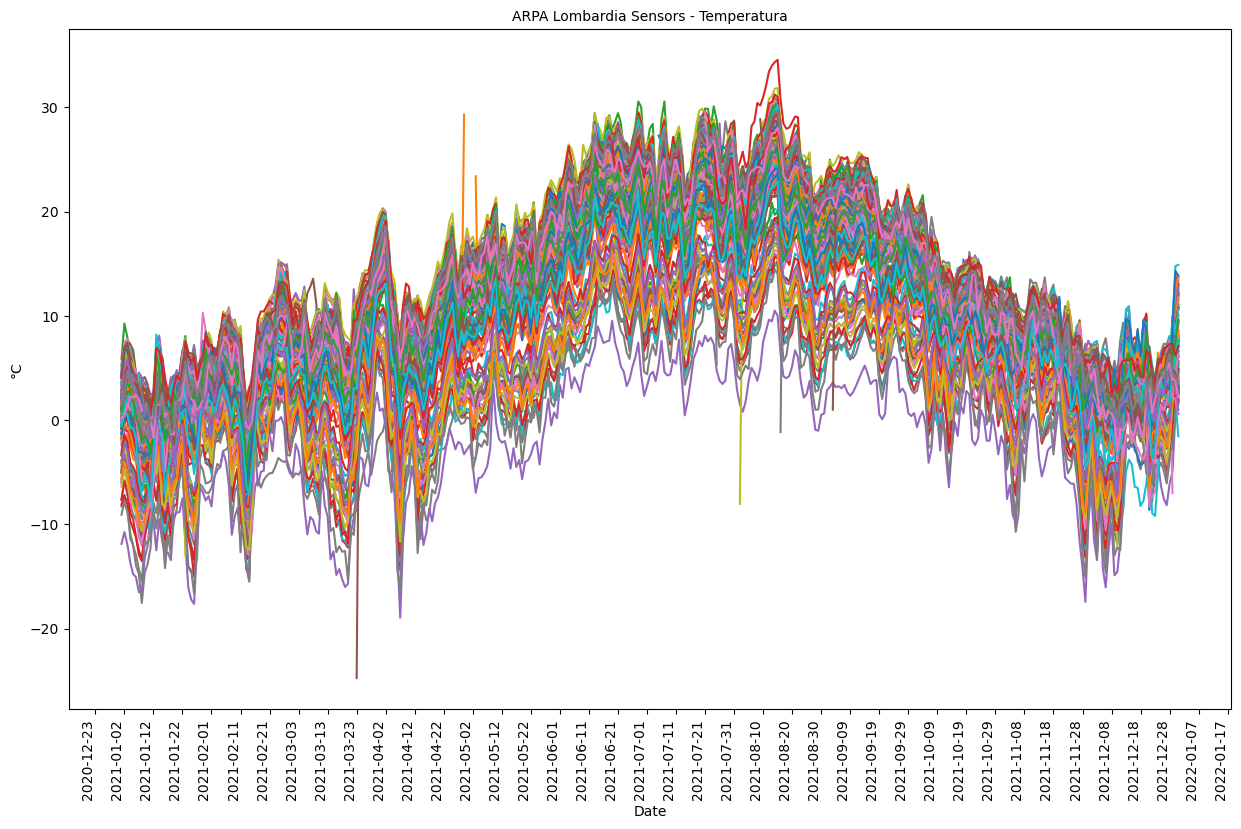

In [113]:
# Create a new figure
fig, ax = plt.subplots(figsize=(15, 10))
ax.set_title('ARPA Lombardia Sensors - '+ sensor_sel,fontdict = {'fontsize': 10})
ax.set_ylabel(measure_unit,fontdict = {'fontsize': 10})
ax.set_xlabel('Date',fontdict = {'fontsize': 10})
# Iterate over the sensor IDs
for sensor_id in sensors_list:
    # Get the data for the current sensor
    sensor_data = merged_df[merged_df['idsensore'] == sensor_id]
    # Plot the time series for the sensor
    ax.plot(sensor_data['data'], sensor_data['valore'], label=sensor_id)

# # Add a legend to the plot
# ax.legend()

# Show the plot
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=10))
plt.gcf().autofmt_xdate()
plt.xticks(rotation=90)
plt.show()

In [114]:
# with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
#     print(merged_df.loc[merged_df['idsensore'] == 17573])

### Check highest and lowest values

Select the sensor that provide the lowest value in the dataframe:

In [119]:
min_index = merged_df['valore'].idxmin()
idsensor_min = merged_df.loc[min_index].idsensore
sel_sensor_min = merged_df.loc[sensor_test_agg['idsensore']==idsensor_min]
merged_df.loc[min_index]

idsensore                                                                  17573
data                                                         2021-03-23 00:00:00
valore                                                                -24.743511
tipologia                                                            Temperatura
unit_dimisura                                                                 °C
idstazione                                                                  1880
nomestazione                                                     Lomello Cantona
quota                                                                         84
provincia                                                                     PV
datastart                                                    2018-12-05 00:00:00
storico                                                                        N
cgb_nord                                                                 4996463
cgb_est                     

Select the sensor that provide the highest value in the dataframe:

In [120]:
max_index = merged_df['valore'].idxmax()
idsensor_max = merged_df.loc[max_index].idsensore
sel_sensor_max = merged_df.loc[sensor_test_agg['idsensore']==idsensor_max]
merged_df.loc[max_index]

idsensore                                                                   2433
data                                                         2021-08-15 00:00:00
valore                                                                 34.554861
tipologia                                                            Temperatura
unit_dimisura                                                                 °C
idstazione                                                                   132
nomestazione                                                  Bergamo v.Stezzano
quota                                                                        211
provincia                                                                     BG
datastart                                                    1993-01-01 00:00:00
storico                                                                        N
cgb_nord                                                                 5056541
cgb_est                     

In [121]:
# with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
#     print(sel_sensor_max)

Plot min and max selected sensors:

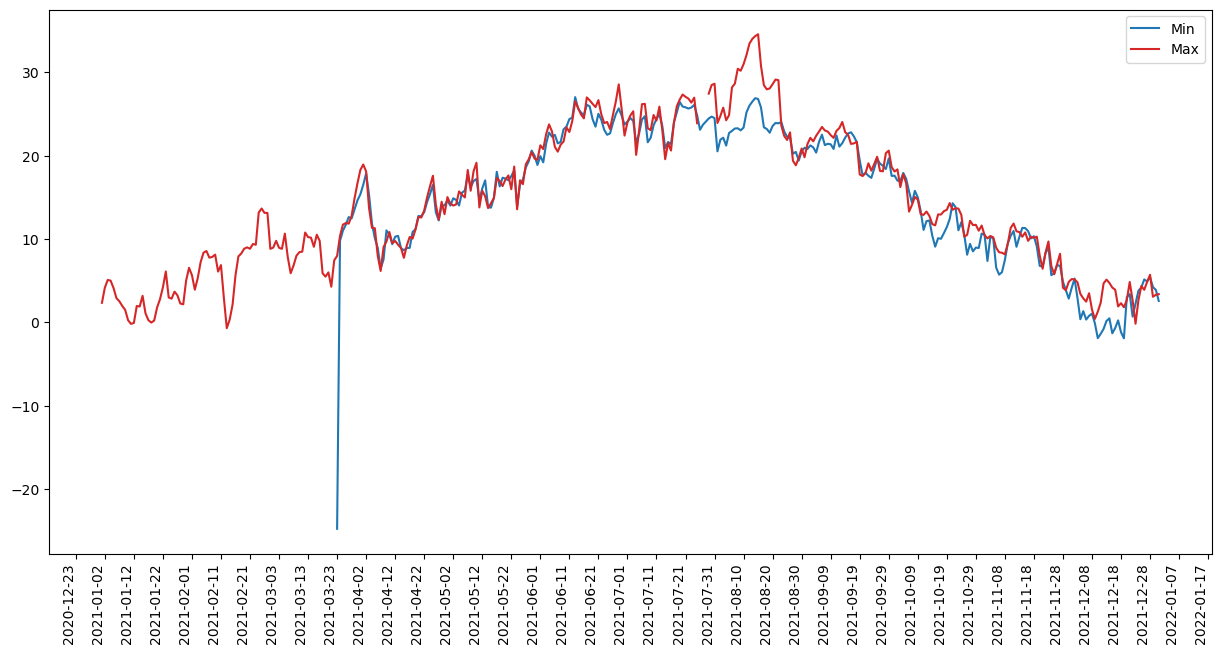

In [122]:
plt.figure(figsize=(15,8))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(mdates.DayLocator())

plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=10))
plt.gcf().autofmt_xdate()
plt.xticks(rotation=90)
plt.plot(sel_sensor_min['data'],sel_sensor_min['valore'], '-',  color="tab:blue", label="Min")
plt.plot(sel_sensor_max['data'],sel_sensor_max['valore'], '-',  color="tab:red", label="Max")
plt.legend()

### Box Plot

([<matplotlib.axis.XTick at 0x25a0aa55df0>,
 [Text(0, 0, 'Max'), Text(1, 0, 'Min')])

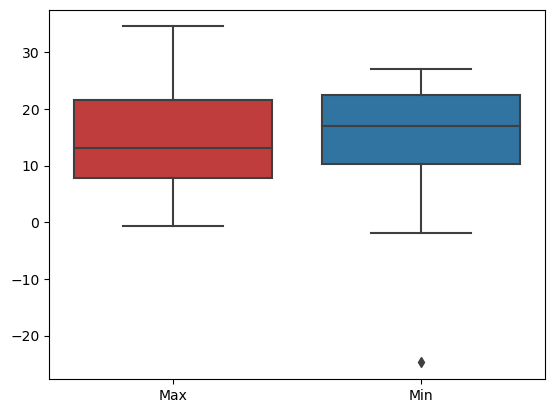

In [123]:
my_pal = {0: "tab:red", 1: "tab:blue"}
sns.boxplot(data=[sel_sensor_max['valore'], sel_sensor_min['valore']], orient="v", palette=my_pal)
plt.xticks([0, 1],["Max","Min"])

### Map

In [124]:
import matplotlib.pyplot as plt
import geopandas as gpd 
import numpy as np
from shapely.geometry import box
from scipy.interpolate import griddata

Import Lombardy and CMM vector files:

In [125]:
lombardy_gdf = gpd.read_file('lombardia_boundary.gpkg')
cmm_gdf = gpd.read_file('CMM.gpkg')

Convert to Geodataframe:

In [126]:
gdf = gpd.GeoDataFrame(merged_df, geometry=gpd.points_from_xy(merged_df.cgb_est, merged_df.cgb_nord), crs="EPSG:32632")

Filter on the dates corresponding to the max and min values found before:

In [127]:
min_date = merged_df.loc[min_index].data
max_date =merged_df.loc[max_index].data

In [128]:
min_date, max_date

(Timestamp('2021-03-23 00:00:00'), Timestamp('2021-08-15 00:00:00'))

In [129]:
max_gdf = gdf.loc[merged_df['data'] == max_date]
min_gdf = gdf.loc[merged_df['data'] == min_date]

Text(0.5, 173.14773259505725, 'East [m]')

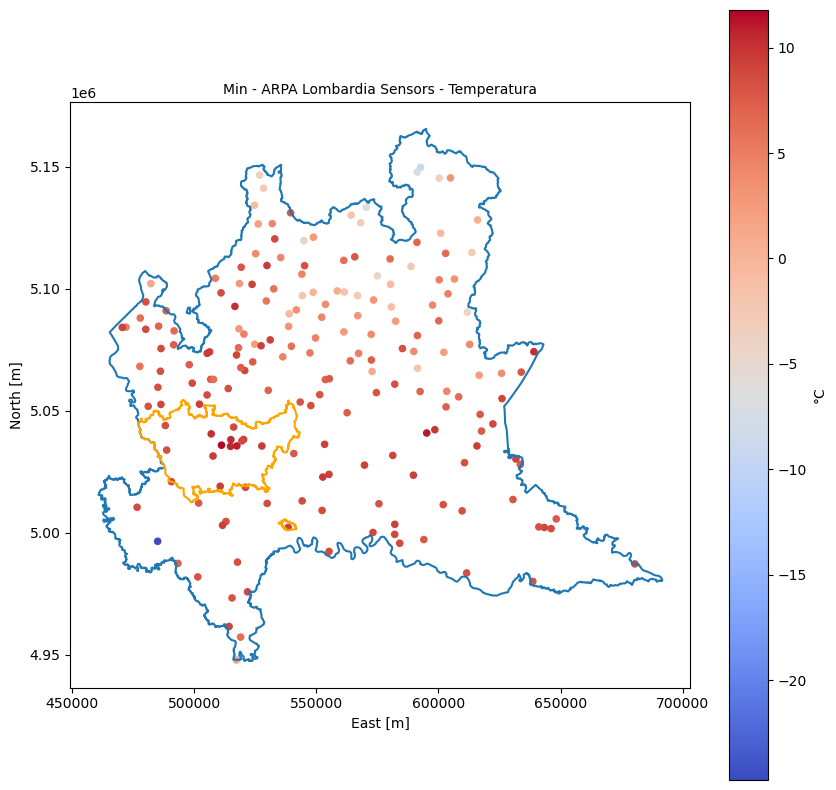

In [135]:
fig, ax = plt.subplots(figsize = (10,10))
min_gdf.plot(ax=ax, markersize=20, column='valore', legend=True, cmap='coolwarm', legend_kwds={'label': measure_unit ,'orientation': "vertical"});
lombardy_gdf.boundary.plot(ax=ax);
cmm_gdf.boundary.plot(ax=ax, edgecolor='orange');
ax.set_title('Min - ARPA Lombardia Sensors - '+ sensor_sel,fontdict = {'fontsize': 10})
ax.set_ylabel('North [m]',fontdict = {'fontsize': 10})
ax.set_xlabel('East [m]',fontdict = {'fontsize': 10})

Text(0.5, 173.14773259505725, 'East [m]')

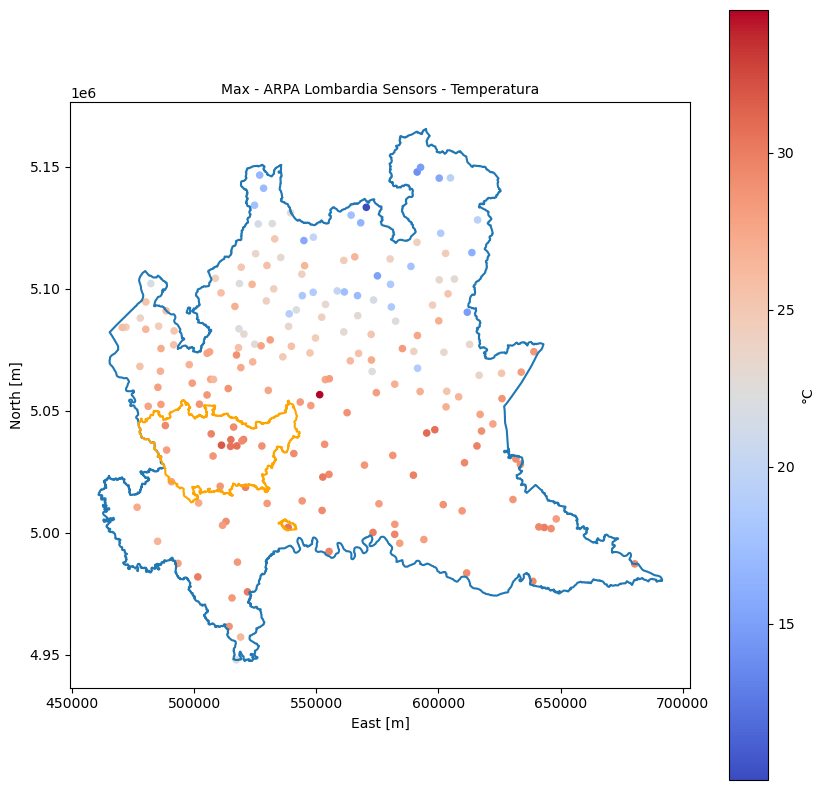

In [136]:
fig, ax = plt.subplots(figsize = (10,10))
max_gdf.plot(ax=ax, markersize=20, column='valore', legend=True, cmap='coolwarm', legend_kwds={'label': measure_unit ,'orientation': "vertical"});
lombardy_gdf.boundary.plot(ax=ax);
cmm_gdf.boundary.plot(ax=ax, edgecolor='orange');
ax.set_title('Max - ARPA Lombardia Sensors - '+ sensor_sel,fontdict = {'fontsize': 10})
ax.set_ylabel('North [m]',fontdict = {'fontsize': 10})
ax.set_xlabel('East [m]',fontdict = {'fontsize': 10})

Text(0.5, 173.14773259505725, 'East [m]')

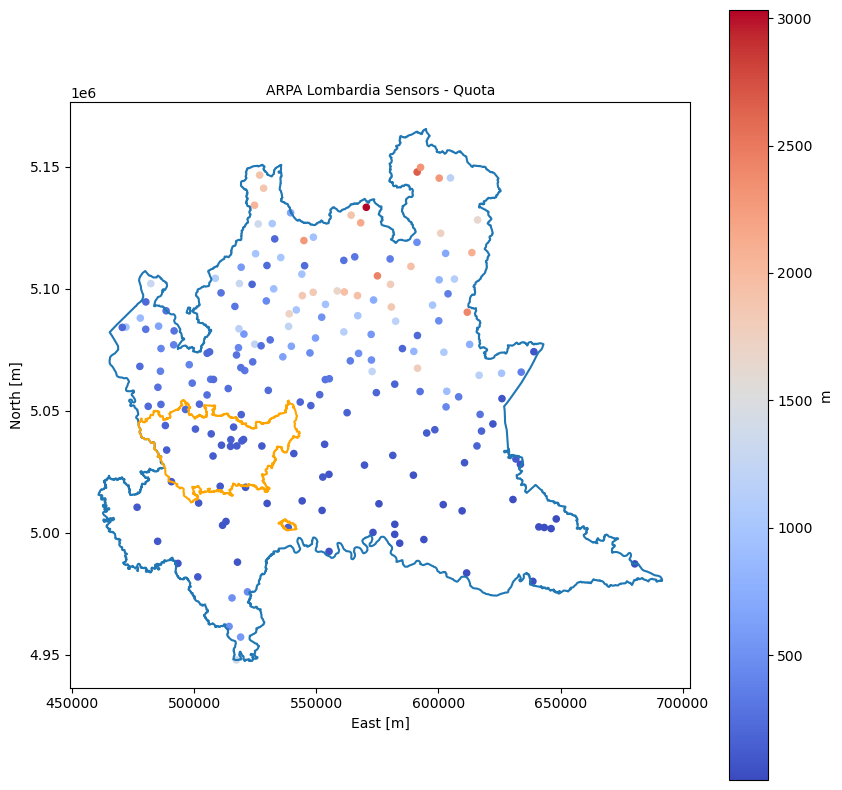

In [137]:
fig, ax = plt.subplots(figsize = (10,10))
max_gdf.plot(ax=ax, markersize=20, column='quota', legend=True, cmap='coolwarm', legend_kwds={'label': 'm' ,'orientation': "vertical"});
lombardy_gdf.boundary.plot(ax=ax);
cmm_gdf.boundary.plot(ax=ax, edgecolor='orange');
ax.set_title('ARPA Lombardia Sensors - Quota',fontdict = {'fontsize': 10})
ax.set_ylabel('North [m]',fontdict = {'fontsize': 10})
ax.set_xlabel('East [m]',fontdict = {'fontsize': 10})

Interactive map (use a small geodataframe)

In [133]:
# gdf_test = gdf
# gdf_test['data'] = gdf_test['data'].astype(str)
# gdf_test = gdf_test.drop(['datastart','datastop'], axis=1)
# m = gdf_test.explore(
#      column="valore",  # make choropleth based on "BoroName" column
#      cmap='OrRd',
#      scheme="naturalbreaks",  # use mapclassify's natural breaks scheme
#      legend=True, # show legend
#      k=10, # use 10 bins
#      legend_kwds=dict(colorbar='OrRd'), # do not use colorbar
#      name="stations") # name of the layer in the map

# lombardy_gdf.explore(m=m,
#                     style_kwds=dict(fill=False))

## Other useful functions

In [ ]:
# def remove_csv_file(filename):
#     if os.path.exists(filename):
#         print("Csv file removed from folder")
#         os.remove(filename)
#     else:
#         print("The file does not exist")

In [ ]:
# remove_csv_file(csv_file)

In [ ]:
# from scipy import stats

# def zscore_filter(df, zscore_tr=3):

#     grouped = df.groupby('idsensore')
    
#     # for each group, calculate the z-scores and remove the outliers
#     for name, group in grouped:
#         df['z_scores'] = stats.zscore(group['valore'], nan_policy='omit')
#         df = df[(df['idsensore'] != name) | (df['z_scores'].abs() <= zscore_tr)]
 
#     return df

In [ ]:
# # backup 
#     #Create list of sensor integer
#     sens_list = list(map(int, sens_list_str))
    
#     #Create sensors list formatted for query
#     ids_str = ""
#     for i in sens_list:
#         ids_str += f"\'{str(i)}\',"
#     ids_str = ids_str[:-1]
#     ids_str += ""
    
#     #Select the Open Data Lombardia Meteo sensors dataset
#     weather_sensor_id = "647i-nhxk"
    
#     #Convert to string in year-month-day format, accepted by ARPA query
#     start_date = start_date.strftime("%Y-%m-%dT%H:%M:%S.%f")
#     end_date = end_date.strftime("%Y-%m-%dT%H:%M:%S.%f")
    
#     print("--- Starting request to ARPA API ---")
    
#     t = time.time()
    
#     #Query data
#     query = """
#       select
#           *
#       where data >= \'{}\' and data <= \'{}\' and idsensore in ({}) limit 9999999999999999
#       """.format(start_date, end_date, ids_str)